# HW 3

## Assume you are looking for faint gamma-rays in a gamma-ray spectrometer. The instrument works by looking at 1000k independent energy channels; and recording a hit in each channel. However, as always, there are both instrumental and environmental backgrounds. Assume you have a background rate per energy channel of 5.3 hits/channel in each 1 second measurement period.

### A. Assume you are looking for gamma-rays at a known energy (one channel), and your signal is steady in time. Pick an emission rate (0.1-10 gamma's per second), and calculate how long you would need to average to obtain a 5 sigma detection.

### B. Assume you are looking for rare bursts of gamma-rays at a known energy. For homework convenience, assume nature has provided gamma-ray bursts that are exactly as long as the integration time you found in part A. If you are searching through 2 months of data, how bright must a burst of gamma-rays be for you to have a 5 sigma detection? Compare to answer in part A.

### C. Now repeat problem B, but this time you don't know which of the 1000k energy channels the mono-energetic burst of gamma-rays might appear in.

### D. Describe (no need to actually do the calculation), how you would search for a burst of unknown duration, and how to determine the trials factor.

In [2]:
import numpy as np 
import astropy.units as u
import astropy.constants as c 
from scipy.integrate import quad, simpson
import scipy.special as special
from scipy.stats import expon, norm, erlang, poisson 
import scipy
import matplotlib.pyplot as plt 

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 25

# update various fontsizes to match
params = {'figure.figsize': (11, 11),
          'legend.fontsize': 13,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

### Part A: 

Notes from questions in class and talking with Megan about the questions that she asked: 
- What distribution should we be using? 
    - a POISSON => why do we know this? => well the problem describes a discrete thing which means that there will be finite values (integers) SO we will need to use a poisson 
    - there is also a constant background => why we know => is there a photon or not? 
    - the AVERAGE creates a 5.3 hits/channel 
- So we have a detector that looks at 100,000 wavelengths but for this part we are just looking at ONE of them and we want to create a distrubution and then determine what is "SIGNAL" like 
    - So we know the background rate: 5.3 gamma/sec 
    - we can figure out the signal rate: signal = 3 + background 
    - so what we need to do is figure out how long we would need to average so that we can get a 5 sigma detection so we would do something simular to what I did in the previous homework but instead of AVERAGING or doing the sum(obs)/Nobs I NEED to take the SUM(obs) becuase we want to maintain the poisson"ness" of the distribution 
    - by doing this I will have the same mean that is just scaled by Nobs 
    - so in programmy terms this would mean that the previous mu = 5.3 but new_mu = 5.3*Nobs 
    - this will change the signal so that instead of signal = signal + back, signal_new = signal*Nobs 
    - knowing this I need to get the probability P as cdf(inf)-cdf(new_signal) and to get sigma I can do norm.ppf(1-P) so running this through a for loop means I can find when I get a signal that produces a 5 sigma detection. 

In [3]:
#I want to test my theory by doing a "sanity" check and then I will run the for loop that I described 

bg_rate = 5.3 #remember this is gamma/sec 
signal = 3 + bg_rate #the problem said to pick btw 0.1 and 10 so I picked 3, this is still gonna be gamma/sec 

#Now I just need to make a random poisson sample so this is very similar to what I did in HW 2 
sample = poisson.rvs(bg_rate, size=int(1e6))

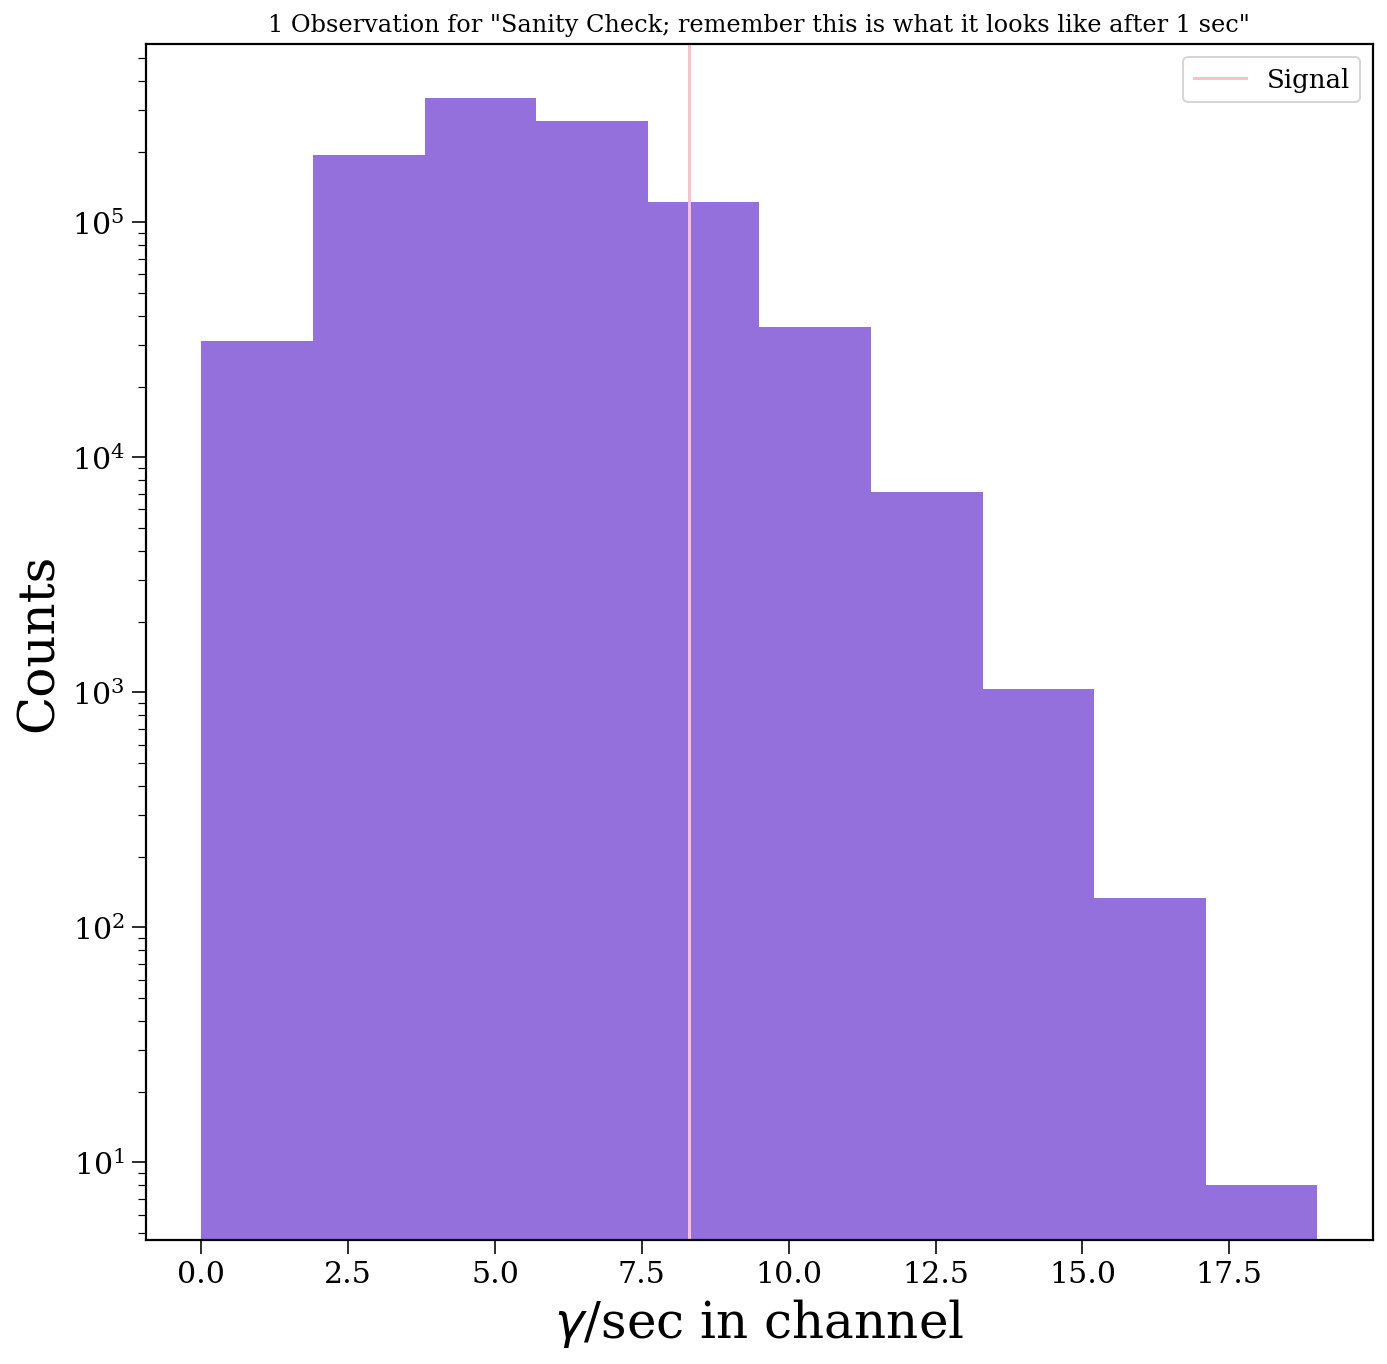

In [48]:
#plot one observation 
plt.hist(sample, color = 'mediumpurple')
plt.axvline(signal, color = 'pink', label = 'Signal')
plt.xlabel('$\gamma$/sec in channel')
plt.ylabel('Counts')
plt.title('1 Observation for "Sanity Check; remember this is what it looks like after 1 sec"')
plt.semilogy()
plt.legend()
plt.show()

In [55]:
#Now I want to do what I walked through but using math so that I can get the sigma value, similar to HW 2 
p_1obs = poisson.cdf(np.inf,bg_rate) - poisson.cdf(signal, bg_rate)

sigma_1obs = norm.ppf(1-p_1obs)
print('The sigma after one observation using signal 3 + background is', sigma_1obs)

The sigma after one observation using signal 3 + background is 1.3441733227808015


In [56]:
#Cool so that looks like it is working, so need to implement my for loop idea 
N = 10 
sigma = sigma_1obs
while sigma < 5: 
    #have to multiply the signal by Nobs to get the new signal and also the bg_rate to make sure it is scaled correctly 
    Psum = poisson.cdf(np.inf, bg_rate*N) - poisson.cdf(signal*N, bg_rate*N)
    sigma = norm.ppf(1-Psum)
    N = N+1
    
N = N-1
print('Number of observations/samples', N)
print('To get:', sigma)

#yay i got the answer so now I can move on to part b 

Number of observations/samples 17
To get: 5.010256704886929


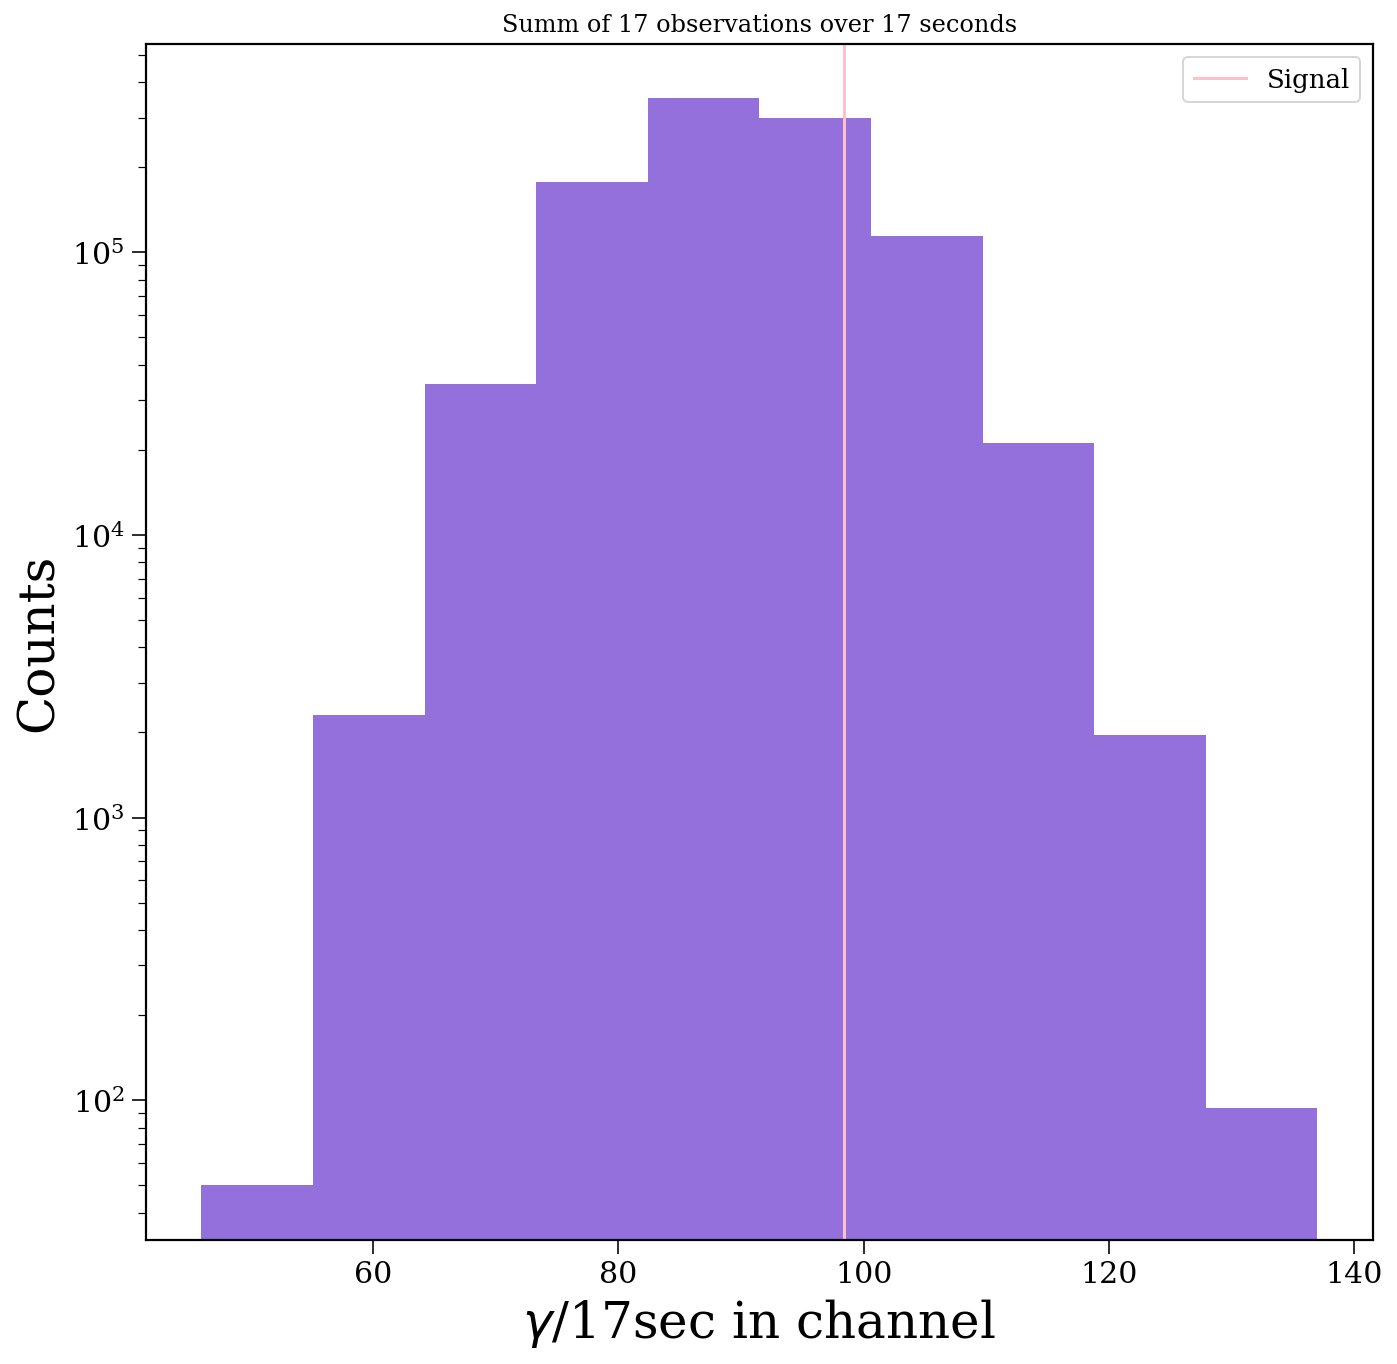

In [27]:
#Just for fun this is what that new summed distribution looks like 
#plot one observation 
sum_sample = poisson.rvs(bg_rate*N, size=int(1e6))
new_signal = signal + bg_rate*N
plt.hist(sum_sample, color = 'mediumpurple')
plt.axvline(new_signal, color = 'pink', label = 'Signal')
plt.xlabel('$\gamma$/17sec in channel')
plt.ylabel('Counts')
plt.title('Summ of 17 observations over 17 seconds')
plt.semilogy()
plt.legend()
plt.show()

### Part B: 

Notes from the questions asked in class and when talking to Megan about the questions that she asked 
- What is the integration time? 
    - it is how long the GRB lasts 
- Looking for how bright does the signal need to be to get a 5 sigma detection? 
- The data that we are looking through is over a 2 month period 

Example: 
- Lets say that it takes a month of integration time so you would look 2 times so then 2 is the trail factor so then the data is mutiplied by 2 so it is BOOSTED => the distribution gets higher and bigger 
    - if I am understanding the problem we would multiply the data by 17 since it took that long to get to a 5 sigma detecton so we are boosting the data by 17?? 
        - Since we need to take 17 observations to get a 5 sigma that means it takes 17 seconds, SO need to figure out how many times (or basically the integration time) => how many 17 seconds are in a 2 month period 
        - 2 months = 30 + 31 days = 61 days 
        - 1 day = 24 hrs 
        - 1 hr = 60 min 
        - 1 min = 60 sec 
- thus to think about this we have to think of the sum that we took is our "new starting point" and the boost is the new thing we are moving to. 
    - remember that only whole number integrations can be made and we are just shifting the data up NOT summing 
- because of this shifting and multiplying, there is going to be BIGGER area than we calculated before where the Psum < Pboosted and Pboosted now has a smaller sigma value (so not at 5 anymore)
    - Pboosted = Ntrials * Psum => essentially looking for that bright source value for all of this to make sense 

In [20]:
#Like I said in my notes, N=17 observations takes 17 seconds so we need to take that into account 

I_time = N #sec
search_time = 61 * 24 * 60 * 60 #days => sec for 2 months (30+31)
windows = search_time/I_time #dimensionless 

print('Whole integrations Windows:', np.floor(windows)) #did floor and not round to not over estimate

Whole integrations Windows: 310023.0


In [29]:
#So we kinda have to work backwards from what we did before ish 
#The goal is to find the sinal that "matches" the signal from before now that we have boosted the summed data 

Pboost = Psum/np.floor(windows) #using the formula from my notes 
sigma_boost = norm.ppf(1-Pboost)
print(sigma_boost)

7.0528209339577685


In [35]:
#So this makes sense becasue we boosted the data so there is a bigger area so now the sigma is greater
    #Need to get the sigma back down to 5 and print out what the signal is that corresonds to that for this boosted data 
    
#I was not really sure how to do this so I talked with Megan (who had talked with Miguel and Bryna) and she said that a good idea 
#is to use an inverse "survival function"  

boost_signal = poisson.isf(Pboost, bg_rate*N) #signal that matches 17 second from the summation 
boost_signal_persec = boost_signal/N #want it in terms of seconds

print('Signal Strength (need this amount of signal above the BG):', boost_signal_persec-bg_rate) #gamma/sec 

Signal Strength (need this amount of signal above the BG): 4.405882352941176


In [33]:
#How many times stronger is this that our original signal? => just divide by the OG signal 3 

print('How many times stronger than OG signal?:', (boost_signal_persec-bg_rate)/3)

How many times stronger than OG signal?: 1.468627450980392


In [31]:
#This value makes sense since it was boosted the signal should be less 17 
#We can determine the confidence of this by checking if it matches 

pcheck = poisson.cdf(np.inf, bg_rate*N) - poisson.cdf(boost_signal_persec*N, bg_rate*N)
sigma_check = norm.ppf(1-pcheck)
print(sigma_check)

#Yay this is pretty close to the boosted sigma so we are on the right track!!! 

7.119592341910446


### Part C: 

So this is similar but we don't know which channel it is in... huh 

I think this means that the number of trials has now increased to 1000k so this is A LOT OF TRIALS 

In [46]:
Niterations = np.floor(windows)*1e6

#Then do the same thing over again 
Pboost_new = Psum/Niterations #using the formula from my notes 
sigma_boost_new = norm.ppf(1-Pboost_new)
print('Sigma Detection when have 1000k channels:', sigma_boost_new)

boost_signal_allchannels = (poisson.isf(Pboost_new, bg_rate*Niterations))/Niterations
boost_signal_overbg = boost_signal_allchannels - bg_rate

print('Signal Strength:', boost_signal_overbg)

print('How many times stronger than OG signal?:', boost_signal_overbg/3)

Sigma Detection when have 1000k channels: inf
Signal Strength: nan
How many times stronger than OG signal?: nan


In [42]:
#oof that is no bueno... I think that there are too many trials and scipy was like what if I didn't give you a value bc I cant 
    #look at probabilities that small 

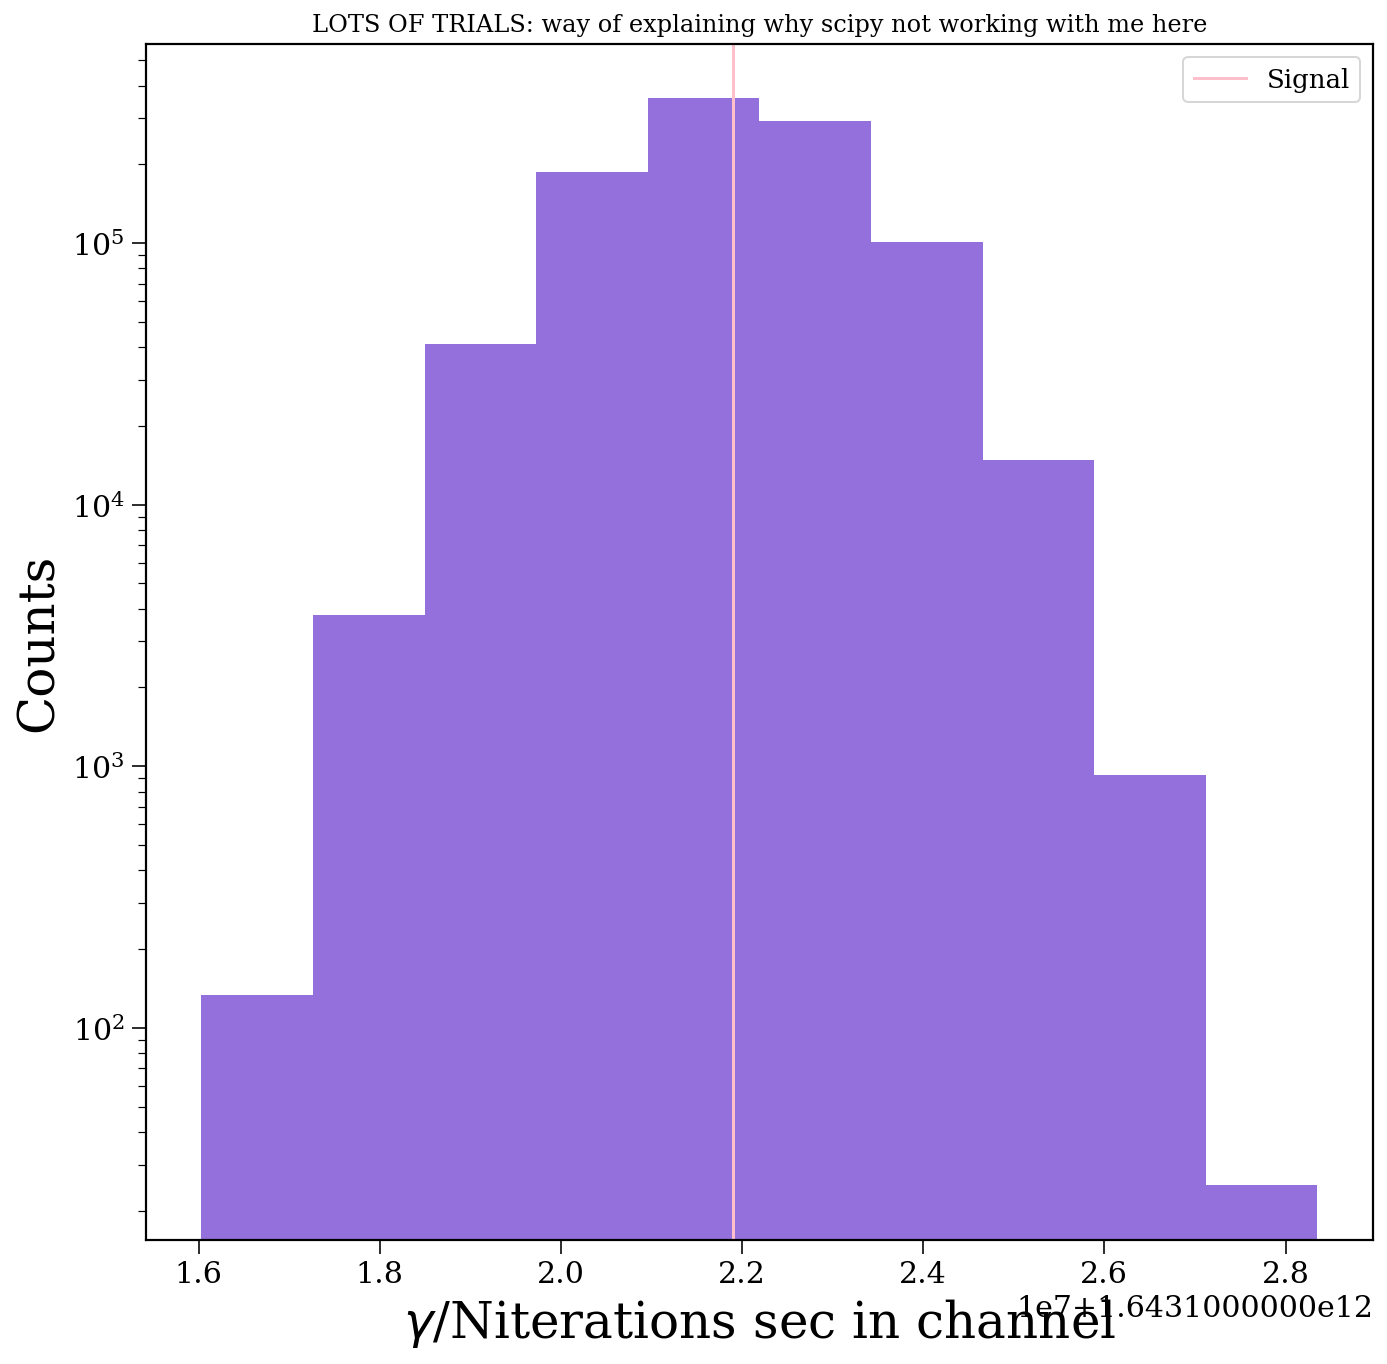

In [45]:
#Just for fun this is what that new summed distribution looks like 
#plot one observation 
sum_sample = poisson.rvs(bg_rate*Niterations, size=int(1e6))
new_signal = signal + bg_rate*Niterations
plt.hist(sum_sample, color = 'mediumpurple')
plt.axvline(new_signal, color = 'pink', label = 'Signal')
plt.xlabel('$\gamma$/Niterations sec in channel')
plt.ylabel('Counts')
plt.title('LOTS OF TRIALS: way of explaining why scipy not working with me here')
plt.semilogy()
plt.legend()
plt.show()

There is just so many trials that the probablility that the original 1 trial distribution that the background would create an event of or greater than the strength that I would have found is v v small.

Just going off of what we saw in PART B, we had that is ~1.5 times stronger than the OG signal so it is going to be at LEAST that many times stronger maybe it doubles so it would be ~3 times stronger but i am not sure 

### Part D: Describe (no need to actually do the calculation), how you would search for a burst of unknown duration, and how to determine the trials factor.

I honestly have no idea (just comprehending part b and c was hard), I think based off of what we were talking about in class this type of problem brings in more dimensions so this moved from a two dimensional problem to a three dimensional problem and I think one way that I would start thinking about it is maybe in terms of covariances? 

So maybe making some corner plots (triangle plots) to see how the long the intergration times and the number of integrations are connected would be a good start? 